# Sentiment Analysis using NLTK

<ins>Date Created/ Submitted: 25 Feb 19</ins>

For this capstone project, the aim is to predict the sentiment of a review using sentiment analysis. And, apply topic modelling using LDA or similar analysis to identify key topics/ area within each sentiment class (e.g. which topics/areas garner mostly negative reviews and which topic/areas garner mostly postive reviews).

This python implementation of this project is split into several python notebooks.
* Part 1: Web-scraping review data (The code for this is not uploaded to github)
* Part 2: Explore the data
* Part 3: Prepare the data (pre-processing)
* Part 4a: Modelling using word vector generated from CountVectorizer
* Part 4b: Modelling using word vector generated from TDIDFVectorizer
* Part 5: Summary Results with Topics Identified

### Part 3. Prepare the data
Note: Output of some cells have been cleared to desensitize the source of the web-scraping.

### Setting Up the Environment

In [1]:
# import various nlp packages
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from nltk import FreqDist
import contractions
import unicodedata

import gensim
from gensim import corpora 

import spacy

from textblob import TextBlob

import csv
import random
import re
import string
import time
from pprint import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Set seed for replicability.
seedno = 18704
np.random.seed(seedno)

# to facilitate viewing full text
pd.set_option('display.max_colwidth', -1)
#pd.options.display.html.use_mathjax = False

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alphaniang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alphaniang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def plot_bars(attribute,setpalette='Spectral',setrotation=0,showlabels=True,sortvalue='ascending',sortcount=None):
    sns.set(style="whitegrid")
# Store frequency counts of each label where unique is the label and counts is its frequency
    unique, counts = np.unique(attribute.astype(str), return_counts=True)
    unique_counts = pd.DataFrame({'Value': unique, 'Count': counts})
    if sortvalue == 'descending':
        unique_counts = unique_counts.sort_values('Value', ascending=False)
    if sortvalue == 'ascending':
        unique_counts = unique_counts.sort_values('Value', ascending=True)
    if sortcount == 'descending':
        unique_counts = unique_counts.sort_values('Count', ascending=False)
    if sortcount == 'ascending':
        unique_counts = unique_counts.sort_values('Count', ascending=True)

# plot frequency counts
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.barplot(x="Value", y="Count", data=unique_counts,palette=setpalette)
    if showlabels==True:
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height),
            ha="center") 
    plt.setp(ax.get_xticklabels(), rotation=setrotation)
    plt.show()

### Restaurant Reviews
### Read in files (from directory) for analysis 

In [3]:
rreviews = pd.read_csv('restaurant_reviews.csv')
rreviews = rreviews.drop(['Unnamed: 0'], axis=1)
rreviews = rreviews.drop(['restaurant_url'], axis=1)

In [5]:
rreviews.shape

(451065, 13)

In [ ]:
# display first two document text
display(rreviews.head(2))

### Data Preparation

In [5]:
# rename columns for personal preference
rreviews['type']='restaurant'
rreviews['id']=rreviews['restaurant_id']
rreviews['name']=rreviews['restaurant_name']
rreviews = rreviews.drop(['restaurant_id','restaurant_name'], axis=1)

In [6]:
# change date columns from string to date type
import datetime
date_format = '%Y/%m/%d'
rreviews['review_date'] = pd.to_datetime(rreviews['review_date'])
rreviews['experience_date'] = pd.to_datetime(rreviews['experience_date'])

In [7]:
# extract user id from user review id column
user_id=[]
for ruser_review_id in rreviews['user_review_id']:
    user_id.append(str(ruser_review_id).split('-')[0])
rreviews['user_id']=user_id
rreviews = rreviews.drop(['user_review_id'], axis=1)

In [8]:
# join review title and body to form review text
rreviews["review_text"] = rreviews["review_title"].map(str) + ". " \
                        + rreviews["review_body"].map(str)
rreviews = rreviews.drop(['review_title','review_body'], axis=1)

In [9]:
# normalise reviews
review_text=[]
for rtext in rreviews['review_text']:
    review_text.append(re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', \
                              r'\1 ', rtext))
rreviews['review_text']=review_text

In [10]:
# reorder columns
rreviews = rreviews[['type','id', 'name', 'review_id', 'rating', 
                     'review_text', 'review_date', 
                     'experience_date', 'contributions', 'helpful_vote',
                     'user_id', 'user_name', 'user_location']]

In [11]:
rreviews.columns.tolist()

['type',
 'id',
 'name',
 'review_id',
 'rating',
 'review_text',
 'review_date',
 'experience_date',
 'contributions',
 'helpful_vote',
 'user_id',
 'user_name',
 'user_location']

In [ ]:
# display first two document text
display(rreviews.head(2))

In [13]:
display(rreviews.shape)

(451065, 13)

## Feature Extraction/ Generation from Text Data

In [14]:
#assign a polarity score with rating 40 and 50 as 1 for positive 
# 30 as neutral and 10, 20 as negative
rating_polarity=[]
for rating in rreviews['rating']:
    if rating >= 40:
        rating_polarity.append(1)
    elif rating <= 20:
        rating_polarity.append(-1)
    else:
        rating_polarity.append(0)
rreviews['rating_polarity']=rating_polarity

In [15]:
#print(rreviews[rreviews['rating']==10]['review_text'].head(3))

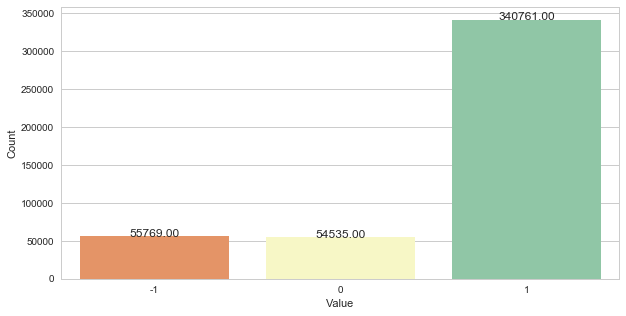

In [16]:
plot_bars(rreviews['rating_polarity'])

In [17]:
rreviews['word_count']= rreviews['review_text'].apply(lambda x: \
                        len(str(x).split(" ")))

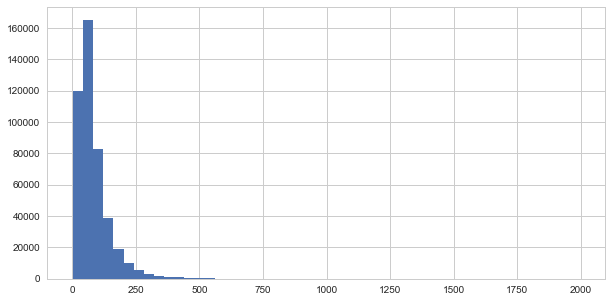

In [18]:
rreviews['word_count'].hist(bins=50,figsize=(10,5))

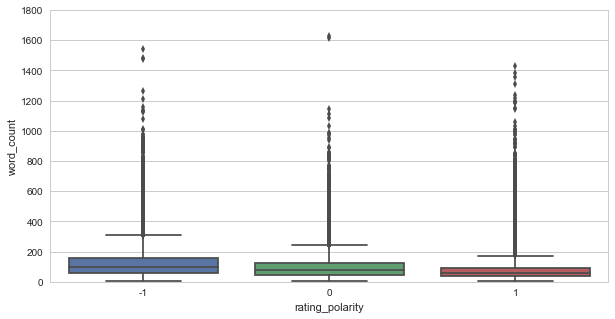

In [19]:
polarity_wordcount = pd.concat([rreviews['word_count'], \
                        rreviews['rating_polarity']], axis=1 \
                        ).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="word_count", \
                  data=polarity_wordcount)
fig.axis(ymin=0, ymax=1800);
plt.show()

In [20]:
rreviews['char_count'] = rreviews['review_text'].str.len() 
#count includes spaces and punctuation

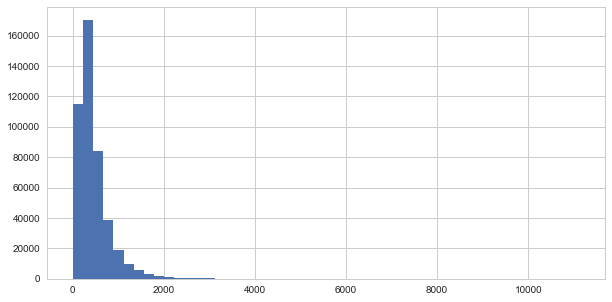

In [21]:
rreviews['char_count'].hist(bins=50,figsize=(10,5))

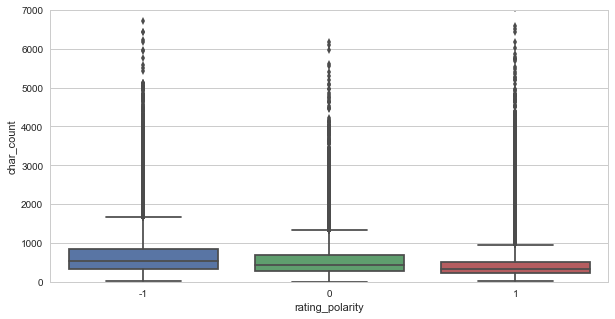

In [22]:
polarity_charcount = pd.concat([rreviews['char_count'], rreviews['rating_polarity']], axis=1).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="char_count", data=polarity_charcount)
fig.axis(ymin=0, ymax=7000);
plt.show()

In [23]:
def avg_word(sentence):
    keep_alpha=re.sub('[^a-zA-Z]+', ' ', sentence)
    words = keep_alpha.split() 
    try:
        avg_word_count=sum(len(word) for word in words)/len(words)
    except (ZeroDivisionError):
        avg_word_count=0
    return avg_word_count

rreviews['avg_word_len'] = rreviews['review_text'].apply(lambda x: \
                            avg_word(x))

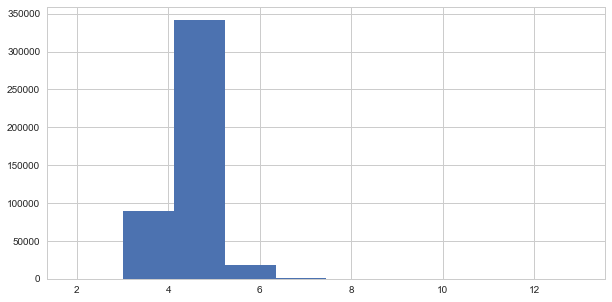

In [24]:
rreviews['avg_word_len'].hist(bins=10,figsize=(10,5))

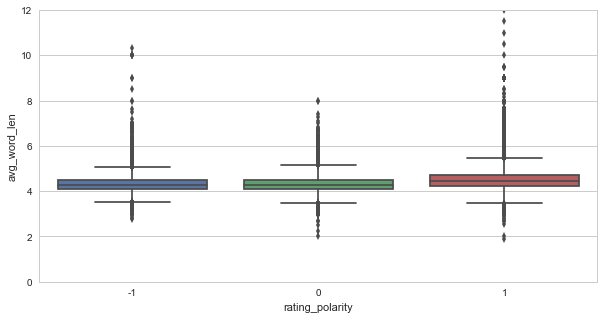

In [ ]:
polarity_avgwordlen = pd.concat([rreviews['avg_word_len'], rreviews['rating_polarity']], axis=1).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="avg_word_len", data=polarity_avgwordlen)
fig.axis(ymin=0, ymax=12);
plt.show()

In [ ]:
stopwords_list = stopwords.words('english')
rreviews['stopword_count'] = rreviews['review_text'].apply(lambda \
                            x: len([x for x in x.lower().split() \
                            if x in stopwords_list]))

In [ ]:
rreviews['stopword_count'].hist(bins=50,figsize=(10,5))

In [ ]:
polarity_stopwordcount = pd.concat([rreviews['stopword_count'], rreviews['rating_polarity']], axis=1).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="stopword_count", data=polarity_stopwordcount)
fig.axis(ymin=0, ymax=800);
plt.show()

In [ ]:
rreviews['stop_perword'] = rreviews['stopword_count'] \
                            / rreviews['word_count']
rreviews = rreviews.drop(['stopword_count'], axis=1)

In [ ]:
polarity_stopperword = pd.concat([rreviews['stop_perword'], rreviews['rating_polarity']], axis=1).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="stop_perword", data=polarity_stopperword)
fig.axis(ymin=0, ymax=1);
plt.show()

In [31]:
punc_list = set(string.punctuation) 
rreviews['punc_count'] = rreviews['review_text'].apply(lambda x: \
                            len([ch for ch in str(x).lower() \
                            if ch in punc_list]))

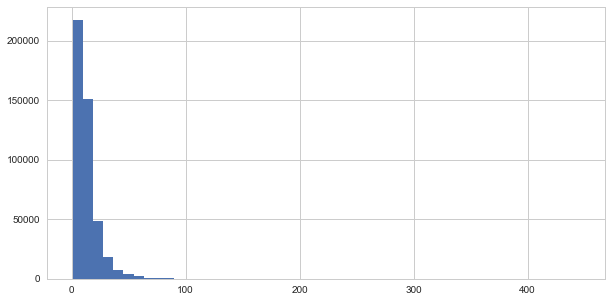

In [32]:
rreviews['punc_count'].hist(bins=50,figsize=(10,5))

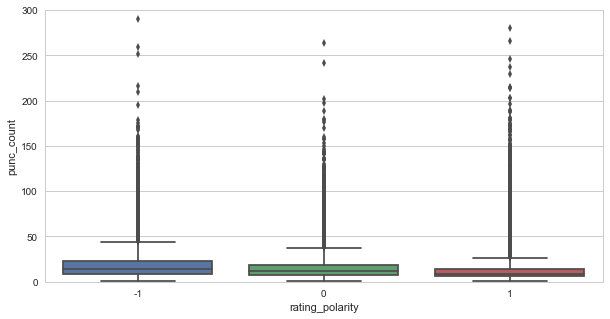

In [33]:
polarity_punccount = pd.concat([rreviews['punc_count'], rreviews['rating_polarity']], axis=1).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="punc_count", data=polarity_punccount)
fig.axis(ymin=0, ymax=300);
plt.show()

In [34]:
rreviews['punc_perchar'] = rreviews['punc_count']/rreviews['char_count']
rreviews = rreviews.drop(['punc_count'], axis=1)

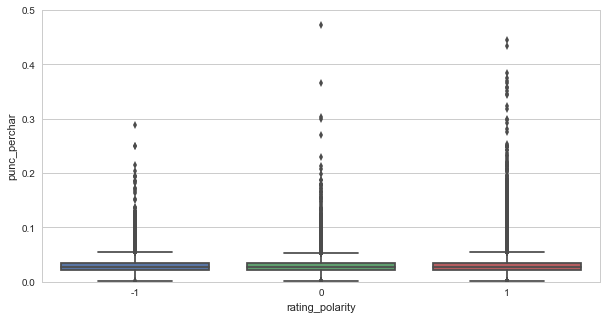

In [35]:
polarity_puncperchar = pd.concat([rreviews['punc_perchar'], rreviews['rating_polarity']], axis=1).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="punc_perchar", data=polarity_puncperchar)
fig.axis(ymin=0, ymax=0.5);
plt.show()

In [36]:
alpha_count=[]
for text in rreviews['review_text']:
    alpha_count.append(len(re.sub('[^a-z]+', '', str(text).lower())))
rreviews['alpha_count']=alpha_count

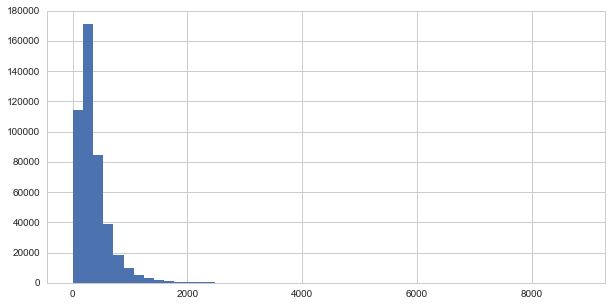

In [37]:
rreviews['alpha_count'].hist(bins=50,figsize=(10,5))

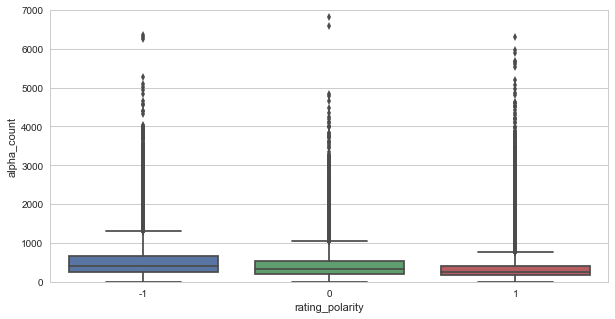

In [38]:
polarity_alphacount = pd.concat([rreviews['alpha_count'], rreviews['rating_polarity']], axis=1).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="alpha_count", data=polarity_alphacount)
fig.axis(ymin=0, ymax=7000);
plt.show()

In [39]:
rreviews['alpha_perchar'] = rreviews['alpha_count']/rreviews['char_count']
rreviews = rreviews.drop(['alpha_count'], axis=1)

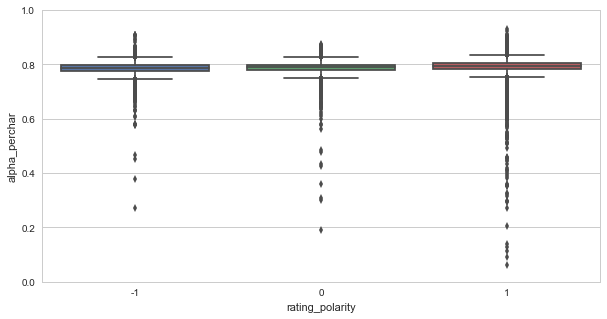

In [40]:
polarity_alphaperchar = pd.concat([rreviews['alpha_perchar'], rreviews['rating_polarity']], axis=1).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="alpha_perchar", data=polarity_alphaperchar)
fig.axis(ymin=0, ymax=1);
plt.show()

In [41]:
rreviews['numeric_count'] = rreviews['review_text'].apply(lambda x: \
                            len([x for x in x.split() if x.isdigit()]))

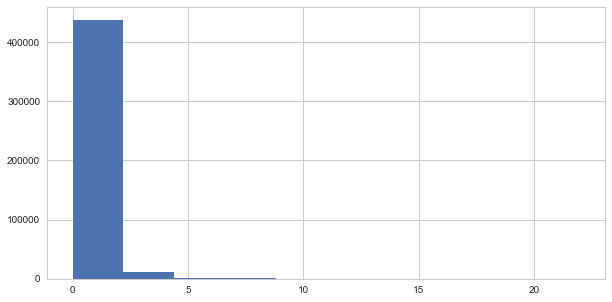

In [42]:
rreviews['numeric_count'].hist(bins=10,figsize=(10,5))

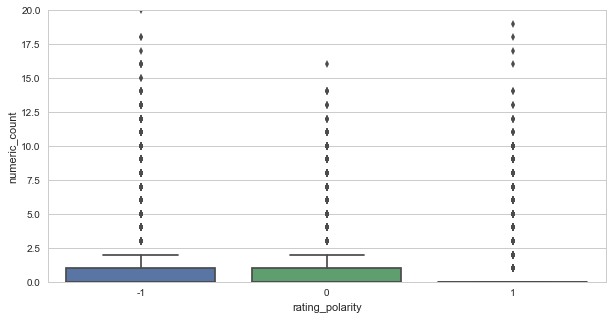

In [43]:
polarity_numericcount = pd.concat([rreviews['numeric_count'], rreviews['rating_polarity']], axis=1).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="numeric_count", data=polarity_numericcount)
fig.axis(ymin=0, ymax=20);
plt.show()

In [44]:
rreviews['uppercase_count'] = rreviews['review_text'].apply(lambda x: \
                            len([x for x in x.split() if x.isupper()]))

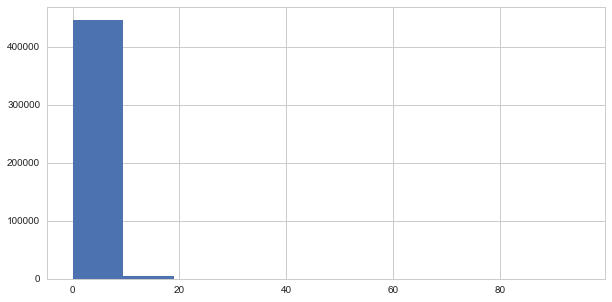

In [45]:
rreviews['uppercase_count'].hist(bins=10,figsize=(10,5))

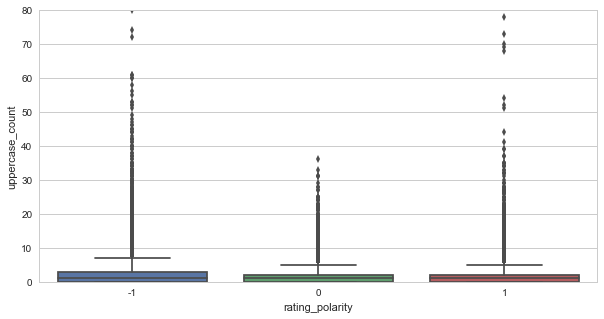

In [46]:
polarity_uppercount = pd.concat([rreviews['uppercase_count'], rreviews['rating_polarity']], axis=1).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="uppercase_count", data=polarity_uppercount)
fig.axis(ymin=0, ymax=80);
plt.show()

In [47]:
rreviews['upper_perchar'] = rreviews['uppercase_count']/rreviews['char_count']
rreviews = rreviews.drop(['uppercase_count'], axis=1)

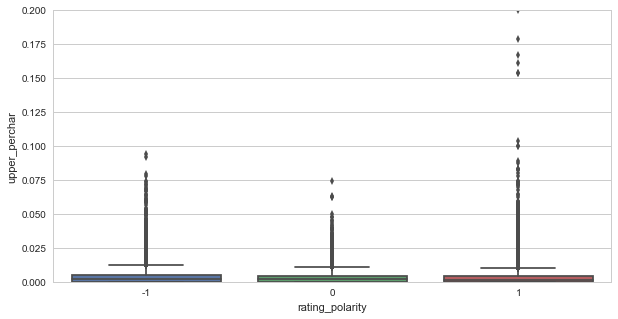

In [48]:
polarity_upperperchar = pd.concat([rreviews['upper_perchar'], rreviews['rating_polarity']], axis=1).sort_values(by='rating_polarity')
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='rating_polarity', y="upper_perchar", data=polarity_upperperchar)
fig.axis(ymin=0, ymax=0.2);
plt.show()

In [49]:
rreviews.isnull().sum()

type               0    
id                 0    
name               0    
review_id          0    
rating             0    
review_text        0    
review_date        0    
experience_date    27444
contributions      0    
helpful_vote       0    
user_id            0    
user_name          0    
user_location      72390
rating_polarity    0    
word_count         0    
char_count         0    
avg_word_len       0    
stop_perword       0    
punc_perchar       0    
alpha_perchar      0    
numeric_count      0    
upper_perchar      0    
dtype: int64

In [50]:
len(rreviews['user_location'].unique())

15242

In [51]:
sa4 = pd.read_csv('SA4.csv')
sa4 = sa4['List of SA4'].str.lower().tolist()

In [52]:
user_islocal=[]
for loc in rreviews['user_location'].str.lower():
    islocal=0
    try:
        for w in loc.split(): 
            if w in sa4:
                islocal=1
    except (AttributeError):
        pass
    if islocal==1:
        user_islocal.append(1)
    else:
        user_islocal.append(0)

In [53]:
rreviews['user_islocal']=user_islocal
rreviews = rreviews.drop(['user_location'], axis=1)

In [54]:
# rreviews=rreviews[(rreviews['experience_date'] >= '2016-01-01') \
#                   & (rreviews['experience_date'] <= '2018-12-31')]

In [ ]:
# display first two document text
display(rreviews.head(2))

In [56]:
# rest_reviewcount=rreviews.groupby(by='id')['id'].count()

In [57]:
# rreviews=rreviews[rreviews['id'].isin(rest_reviewcount[ \
#                         rest_reviewcount >=100].keys())]

In [58]:
rreviews.isnull().sum()

type               0    
id                 0    
name               0    
review_id          0    
rating             0    
review_text        0    
review_date        0    
experience_date    27444
contributions      0    
helpful_vote       0    
user_id            0    
user_name          0    
rating_polarity    0    
word_count         0    
char_count         0    
avg_word_len       0    
stop_perword       0    
punc_perchar       0    
alpha_perchar      0    
numeric_count      0    
upper_perchar      0    
user_islocal       0    
dtype: int64

In [59]:
rreviews.shape

(451065, 22)

In [60]:
# write dataframe to csv for exploration with other visualization tools
rreviews.to_csv('rreviews.csv')